In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# dataset_folder = "datasets/financial"
dataset_folder = "datasets/healthcare"
# dataset_folder = "datasets/eligibility"



# Init memories

In [4]:
import os

from cama.memory import WorkingMemory, EpisodicMemory, SemanticMemory
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import json

from docarray import BaseDoc, DocList
from typing import Tuple, List
from rich import print



df_reference = pd.read_csv(f"{dataset_folder}/initial.csv")
df_current = pd.read_csv(f"{dataset_folder}/drifted.csv")

with open(f'{dataset_folder}/dataset_description.json', 'r') as f:
    dataset_description = json.load(f)

# Split initial dataset into training and testing sets
label_name = dataset_description["LABEL"]
X_reference = df_reference.drop(columns=[label_name])
y_reference = df_reference[label_name]
X_train_reference, X_test_reference, y_train_reference, y_test_reference = train_test_split(X_reference, y_reference, test_size=0.2, random_state=42)

# Split drifted dataset into training and testing sets
X_current = df_current.drop(columns=[label_name])
y_current = df_current[label_name]
X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(X_current, y_current, test_size=0.2, random_state=42)

X_train_reference.head()

,Age,BMI,Blood Pressure,Cholesterol,Physical Activity,Smoking Status,Diet Quality,Family History,Income,Education Level
29,60,27.8,159,221,2,1,1,0,65622.102513,2
535,63,29.4,142,206,4,1,1,0,56636.071795,2
695,27,30.4,164,194,5,1,1,1,34015.418628,1
557,60,31.1,146,238,5,1,1,0,36821.466688,3
836,52,25.9,127,239,2,1,1,1,49938.397964,2


In [5]:
from sklearn.ensemble import RandomForestClassifier

model_reference = RandomForestClassifier(random_state=42)
model_reference.fit(X_train_reference, y_train_reference)

# Test the model on the initial test set
initial_accuracy = model_reference.score(X_test_reference, y_test_reference)
print(f'Model trained and evaluated on the reference distribution: {initial_accuracy}')

Model trained and evaluated on the reference distribution: 0.88

## Episodic memory

In [6]:
from cama.memory import CurrentDataset


current_dataset = CurrentDataset(X=X_test_current, y_current=None, description=dataset_description)
first_episodic_memory = EpisodicMemory(current_dataset=current_dataset, task=0)
init_episodic_memory = DocList[EpisodicMemory]([first_episodic_memory])
# episodic_memory[0]


## Semantic memory

In [7]:
from cama.tools import get_tools
from cama.tools import get_drift_report, get_shap_values
from cama.memory import ReferenceDataset


tools = get_tools([get_drift_report, get_shap_values])


# At the beginning, the agent has 1 entry in the semantic memory. 
reference_dataset = ReferenceDataset(X_train=X_train_reference, 
                                     X_test=X_test_reference, 
                                     y_train=y_train_reference, 
                                     y_test=y_test_reference, 
                                     description=dataset_description)

init_semantic_memory = SemanticMemory(reference_dataset=reference_dataset, 
                                 tools=tools, model=model_reference)
# semantic_memory

## Dataset representation

In [8]:
from cama.representation import get_dataset_representation

get_drift_report_function = init_semantic_memory.tools['get_drift_report'].function
get_shap_values_report_function = init_semantic_memory.tools['get_shap_values'].function

drift_report = get_drift_report_function(init_semantic_memory.reference_dataset.description,
                                         init_semantic_memory.reference_dataset.X_train,
                                         init_episodic_memory[0].current_dataset.X,
                                         drift_share=0.7,
                                         show_plot=False)['drift_by_columns']

shap_report_train_reference = get_shap_values_report_function(init_semantic_memory.model,
                                                                init_semantic_memory.reference_dataset.X_train,
                                                                init_semantic_memory.reference_dataset.description)
shap_report_test_current = get_shap_values_report_function(init_semantic_memory.model,
                                                            init_episodic_memory[0].current_dataset.X,
                                                            init_episodic_memory[0].current_dataset.description)

shap_report = {feature: {'reference': shap_report_train_reference[feature], 'current': shap_report_test_current[feature]} for feature in shap_report_train_reference}
tools_results = {'get_drift_report': drift_report, 'get_shap_values': shap_report}


dataset_representation = get_dataset_representation(init_semantic_memory, tools_results)
# dataset_representation

# Generate/Load ground truth report

In [9]:
from cama.utils import get_ground_truth_template, generate_ground_truth_prompt

gt_template = get_ground_truth_template(init_semantic_memory,
                                        init_episodic_memory, 
                                        dataset_representation)
gt_prompt = generate_ground_truth_prompt(gt_template)
print(gt_prompt.format())

System: 
    You are an expert in data science and machine learning. Read the following report and complete it by filling 
inside the text '(Here the LLM should provide...)' with your explanations. Keep all the remaining text as it is.


# Comprehensive Report

## Executive Summary

(Here the LLM should provide an executive summary of the report.)

## Dataset Synopsis
**Title**: Chronic Condition Prediction Data  
**Features Analyzed**: Age, BMI, Blood Pressure, Cholesterol, Physical Activity, Smoking Status, Diet Quality, 
Family History, Income, Education Level
**Label Variable**: ChronicCondition  

This dataset simulates the likelihood of individuals developing a chronic condition based on attributes such as 
Age, 
BMI, Blood Pressure, Cholesterol, Physical Activity, Smoking Status, Diet Quality, Family History, Income, and 
Education Level. 
The 'ChronicCondition' variable serves as the label, indicating whether an individual is likely (1) or not likely 
(0) to develop the chronic condition. 


## Label Description
**ChronicCondition**: Indicates the likelihood of developing a chronic condition, with 0 representing no chronic 
condition and 1 representing chronic condition.
(Here the LLM should provide an explanation if the label has issues or not. Remember that the label was not used in
the drift analysis and SHAP values.)

## Feature Analysis

### Feature name: Age
- **Description**: Age of the individual in years, ranging from 18 to 90.
- **Type**: Numerical
- **Possible Values**: Ranging from 18 to 90 years.
- **Data Type**: int

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.03778629771302727
- **Detection**: No drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [31.0, 36.5, 42.0, 47.5, 53.0, 58.5, 64.0, 69.5, 75.0, 80.5, 86.0], 'y': 
[0.002727272727272727, 0.0036363636363636364, 0.013636363636363636, 0.016363636363636365, 0.045454545454545456, 
0.035454545454545454, 0.03363636363636364, 0.02090909090909091, 0.005454545454545454, 0.004545454545454545]}}
  - Reference: {'small_distribution': {'x': [18.0, 25.2, 32.4, 39.6, 46.8, 54.0, 61.2, 68.4, 75.6, 82.8, 90.0], 
'y': [0.00017361111111111112, 0.0005208333333333333, 0.00329861111111111, 0.010416666666666671, 
0.02690972222222221, 0.0392361111111111, 0.03229166666666665, 0.016840277777777805, 0.007291666666666664, 
0.0019097222222222215]}}
  - Interpretation: (Here the LLM should provide an interpretation of the current vs reference distribution. Gives 
examples of the differences.)

#### Feature Attribution Analysis
  - Method: Tree SHAP
  - Training Data: 0.08906002648096621 (Rank 3)
  - Current Data: 0.050937679805919664 (Rank 5)
  - Interpretation: (Here the LLM should provide an interpretation of the current vs reference SHAP values.)

#### Overal Interpretation**: 
  (Here the LLM should provide an overall interpretation for the feature: Age.)

### Feature name: BMI
- **Description**: Body Mass Index of the individual, ranging from 18.5 to 40.0.
- **Type**: Numerical
- **Possible Values**: Ranging from 18.5 to 40.0.
- **Data Type**: float

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.11257326919665277
- **Detection**: Drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [18.41029156979427, 21.42048565665614, 24.43067974351801, 
27.44087383037988, 30.451067917241744, 33.46126200410362, 36.47145609096548, 39.48165017782735, 42.49184426468922, 
45.50203835155109, 48.51223243841296], 'y': [0.004983067392720021, 0.029898404356320126, 0.08139010074776035, 
0.08471214567624047, 0.06644089856960021, 0.03322044928480018, 0.023254314499360128, 0.004983067392720016, 
0.001661022464240005, 0.0016610224642400093]}}
  - Reference: {'small_distribution': {'x': [18.5, 20.61, 22.72, 24.830000000000002, 26.94, 29.05, 
31.160000000000004, 33.27, 35.38, 37.49, 39.6], 'y':

In [10]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from cama.utils import generate_ground_truth_prompt
from cama.utils import extract_markdown
from cama.utils import save_to_file
from cama.utils import load_from_file

load_dotenv('env')

openai_llm = ChatOpenAI(temperature=0.7, model_name="gpt-4o", cache=False)
 
gt_prompt = generate_ground_truth_prompt(gt_template)


file_name = 'gt_report.md'
# Save to file if it doesn't exist
file_path = f'{dataset_folder}/{file_name}'

if os.path.exists(file_path):
    print(f"{file_path} already exists. Loading from file.")
    gt_report = load_from_file(file_path)
else: 
    print(f"Invoking the pipeline to generate the ground truth report.")
    chain = gt_prompt | openai_llm | extract_markdown
    gt_report = chain.invoke({})#.content
    print(f"Saving the ground truth report to {file_path}")
    save_to_file(gt_report, file_path)

# print(gt_report)


datasets/healthcare/gt_report.md already exists. Loading from file.

# Generate/Load queries and answers

In [11]:
from cama.utils import generate_mchoice_qa_prompt, extract_json

number_qa = 40
qa_prompt = generate_mchoice_qa_prompt(gt_report, number_qa)
print(qa_prompt.format())

System: You are an expert in data science.
Human: 
    Generate 40 detailed multiple-choice questions and concise answers based on the following comprehensive report.
    Each question should have five options (A, B, C, D, E) and should cover various aspects of the report. Ensure 
the correct answer is clearly indicated and is unique. 
    Make sure to include numerical comparisons and insights drawn from the current and reference distributions 
wherever applicable:


    # Comprehensive Report

## Executive Summary

This report provides a detailed analysis of a dataset used to predict the likelihood of individuals developing a 
chronic condition based on various features. The analysis includes distribution drift and feature attribution using
SHAP values to understand the influence of each feature on the prediction model. The report highlights key findings
and provides insights into the stability and relevance of the features over time.

## Dataset Synopsis
**Title**: Chronic Condition Prediction Data  
**Features Analyzed**: Age, BMI, Blood Pressure, Cholesterol, Physical Activity, Smoking Status, Diet Quality, 
Family History, Income, Education Level
**Label Variable**: ChronicCondition  

This dataset simulates the likelihood of individuals developing a chronic condition based on attributes such as 
Age, BMI, Blood Pressure, Cholesterol, Physical Activity, Smoking Status, Diet Quality, Family History, Income, and
Education Level. The 'ChronicCondition' variable serves as the label, indicating whether an individual is likely 
(1) or not likely (0) to develop the chronic condition. 

## Label Description
**ChronicCondition**: Indicates the likelihood of developing a chronic condition, with 0 representing no chronic 
condition and 1 representing chronic condition.
The label appears to be well-defined with no issues, as it clearly differentiates between the presence and absence 
of a chronic condition.

## Feature Analysis

### Feature name: Age
- **Description**: Age of the individual in years, ranging from 18 to 90.
- **Type**: Numerical
- **Possible Values**: Ranging from 18 to 90 years.
- **Data Type**: int

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.03778629771302727
- **Detection**: No drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [31.0, 36.5, 42.0, 47.5, 53.0, 58.5, 64.0, 69.5, 75.0, 80.5, 86.0], 'y': 
[0.002727272727272727, 0.0036363636363636364, 0.013636363636363636, 0.016363636363636365, 0.045454545454545456, 
0.035454545454545454, 0.03363636363636364, 0.02090909090909091, 0.005454545454545454, 0.004545454545454545]}}
  - Reference: {'small_distribution': {'x': [18.0, 25.2, 32.4, 39.6, 46.8, 54.0, 61.2, 68.4, 75.6, 82.8, 90.0], 
'y': [0.00017361111111111112, 0.0005208333333333333, 0.00329861111111111, 0.010416666666666671, 
0.02690972222222221, 0.0392361111111111, 0.03229166666666665, 0.016840277777777805, 0.007291666666666664, 
0.0019097222222222215]}}
  - Interpretation: The distributions of age in both the current and reference datasets are similar, indicating no 
significant changes over time. Minor variations in frequencies are observed, but they do not indicate any 
substantial drift.

#### Feature Attribution Analysis
  - Method: Tree SHAP
  - Training Data: 0.08906002648096621 (Rank 3)
  - Current Data: 0.050937679805919664 (Rank 5)
  - Interpretation: The SHAP values for age have decreased in the current data compared to the training data, 
suggesting that age has become slightly less influential in predicting chronic conditions over time.

#### Overall Interpretation**: 
  Age remains an important feature but its influence has decreased slightly in the current dataset compared to the 
training dataset.

### Feature name: BMI
- **Description**: Body Mass Index of the individual, ranging from 18.5 to 40.0.
- **Type**: Numerical
- **Possible Values**: Ranging from 18.5 to 40.0.
- **Data Type**: fl

In [12]:
from cama.utils import save_json_to_file, load_from_json

# chain = qa_prompt | openai_llm | extract_json

file_path = f'{dataset_folder}/qa_list.json'
if os.path.exists(file_path):
    print(f"{file_path} already exists. Loading from file.")
    qa_list = load_from_json(file_path)
else:
    print(f"Invoking the pipeline to generate the QA list.")
    chain = qa_prompt | openai_llm | extract_json
    qa_list = chain.invoke({})
    print(f"Saving the QA list to {file_path}")
    save_json_to_file(qa_list, file_path)

len(qa_list)

datasets/healthcare/qa_list.json already exists. Loading from file.

datasets/healthcare/qa_list.json object loaded successfully

39

## CAMA report/answers

In [13]:
from cama.decision import DecisionProcedure
from langchain_community.chat_models import ChatOllama
from langchain_community.llms import Ollama
from langchain_groq import ChatGroq
from cama.utils import print_function_name
from dotenv import load_dotenv


load_dotenv('env')
llm_name = "llama3-8b-8192"
# llm_name = "llama3-70b-8192"
# llm_name = "mixtral-8x7b-32768"
# llm_name = "gemma-7b-it"

# llm_name = "phi3:14b"
# llm_name = "phi3"

llm_generator = ChatGroq(cache=False, temperature=0.0, model_name=llm_name)
# llm_generator = ChatOllama(model=llm_name, cache=False, temperature=0.0)  #
llm_generator

ChatGroq(cache=False, client=<groq.resources.chat.completions.Completions object at 0x7fc0781687d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7fc0781699d0>, model_name='llama3-8b-8192', temperature=1e-08, groq_api_key=SecretStr('**********'))

In [14]:
from cama.utils import save_to_file

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Monitoring"

# eligibilit threshold = 0.70
# healthcare threshold = 0.65
# finance threshold = 0.35

working_memory = WorkingMemory(episodic_memory=init_episodic_memory, 
                              semantic_memory=init_semantic_memory, 
                              threshold=0.35, generations={})

decision_procedure = DecisionProcedure(llm_generator, debug=False)

# If slow_tools, episodic_memory, or semantic_memory or dataset representation exist in disk laod them
slow_tools_filename = f'{dataset_folder}/slow_tools_{llm_name}.pkl'
episodic_memory_filename = f'{dataset_folder}/episodic_memory_{llm_name}.pkl'
semantic_memory_filename = f'{dataset_folder}/semantic_memory_{llm_name}.pkl'
dataset_representation_filename = f'{dataset_folder}/dataset_representation_{llm_name}.pkl'

if os.path.exists(slow_tools_filename) and \
    os.path.exists(episodic_memory_filename) and \
    os.path.exists(semantic_memory_filename) and \
    os.path.exists(dataset_representation_filename) and \
    os.path.exists(f'{dataset_folder}/cama_agent_report_{llm_name}.md'):
    print("Loading slow_tools, episodic_memory, semantic_memory, and dataset_representation from disk.")
    with open(slow_tools_filename, 'rb') as f:
        slow_tools_results = pickle.load(f)
    with open(episodic_memory_filename, 'rb') as f:
        episodic_memory = pickle.load(f)
    with open(semantic_memory_filename, 'rb') as f:
        semantic_memory = pickle.load(f)
    with open(dataset_representation_filename, 'rb') as f:
        dataset_representation = pickle.load(f)

    # load cama agent report
    cama_agent_report = episodic_memory.deep_insight.generate_markdown_report()
else:
    print("Running the decision procedure.")
    output = decision_procedure.run(working_memory)

    slow_tools_results = output['compile']['slow_tools_results']
    last_episodic_memory = output['compile']['episodic_memory'][-1]
    semantic_memory = output['compile']['semantic_memory']
    dataset_representation = output['compile']['dataset_representation']

    with open(slow_tools_filename, 'wb') as f:
        pickle.dump(slow_tools_results, f)
    with open(episodic_memory_filename, 'wb') as f:
        pickle.dump(last_episodic_memory, f)
    with open(semantic_memory_filename, 'wb') as f:
        pickle.dump(semantic_memory, f)
    with open(dataset_representation_filename, 'wb') as f:
        pickle.dump(dataset_representation, f)
    
    cama_agent_report = last_episodic_memory.deep_insight.generate_markdown_report()
    save_to_file(cama_agent_report, f'{dataset_folder}/cama_agent_report_{llm_name}.md')

    print("Slow tools, episodic_memory, semantic_memory, and dataset_representation saved to disk.")


Loading slow_tools, episodic_memory, semantic_memory, and dataset_representation from disk.

In [15]:
from cama.utils import get_answers_from_report_prompt

get_answer_prompt = get_answers_from_report_prompt(cama_agent_report, qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:


        # Chronic Condition Prediction Data - Deep Insight Report

        ## Overview
        Here is the summary and conclusion based on the given information:

**Summary**

The dataset contains 10 features that aim to predict the likelihood of developing a chronic condition. The features
include Age, BMI, Blood Pressure, Cholesterol, Physical Activity, Smoking Status, Diet Quality, Family History, 
Income, and Education Level. The analysis reveals that some features have drifted significantly between the 
reference and current datasets, which may impact the performance of machine learning models. The features that have
drifted include Income, Education Level, and Blood Pressure. The analysis also shows that some features have a 
significant impact on the model's predictions, including Income, Education Level, and BMI.

**Conclusion**

The analysis of the dataset reveals that some features have drifted significantly between the reference and current
datasets, which may impact the performance of machine learning models. The features that have drifted include 
Income, Education Level, and Blood Pressure. These changes may require adjustments to the model to ensure its 
accuracy and reliability. Additionally, the analysis shows that some features have a significant impact on the 
model's predictions, including Income, Education Level, and BMI. These findings highlight the importance of 
monitoring feature distributions and identifying changes that may impact model performance. By addressing these 
changes, data scientists can improve the accuracy and reliability of machine learning models.

        ## Details

        ### Label Insight
        Based on the provided information, I will explain the label 'ChronicCondition' step by step:

**Label Name:** ChronicCondition

**Description:** Indicates the likelihood of developing a chronic condition, with 0 representing no chronic 
condition and 1 representing chronic condition.

**Type:** Categorical

**Possible Values:** {'0': 'No chronic condition', '1': 'Chronic condition'}

**Data Type:** int

From the description, we can infer that the label 'ChronicCondition' is a categorical variable that indicates the 
likelihood of developing a chronic condition. The possible values for this label are 0 (representing no chronic 
condition) and 1 (representing chronic condition).

The data type of the label is int, which means it is an integer value. This is consistent with the description, 
which mentions that 0 represents no chronic condition and 1 represents chronic condition.

There are no apparent problems or issues with the label based on the provided information. The label is clearly 
defined, and its possible values are well-defined and easy to understand.

In summary, the 'ChronicCondition' label is a categorical variable that indicates the likelihood of developing a 
chronic condition, with possible values of 0 (no chronic condition) and 1 (chronic condition).


            ### Age

            **Feature: Age**

The 'Age' feature represents the age of the individual in years, ranging from 18 to 90. This feature is numerical 
in nature, with a total of 11 possible values: 18, 25.2, 32.4, 39.6, 46.8, 54, 61.2, 68.4, 75.6, 82.8, and 90.

**Get Drift Report**

The Get Drift Report tool was used to analyze the distribution of the 'Age' feature between the reference and 
current datasets. The results indicate that the drift score is 0.03778629771302727, which is below the threshold of
0.1. This suggests that there is no significant drift in the distribution of the 'Age' feature.

The current distribution of the 'Age' feature is as follows:

* Small distribution: x = [31.0, 36.5, 4

In [69]:
method_name = "cama_agent"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# create a blank file "answers_method_filename" on disk 
# !touch $answers_method_filename
answers_method_filename


'datasets/financial/answers_cama_agent_llama3-70b-8192.json'

In [16]:
# Invoke chain only if file does not exist
answers_cama_filename = f'{dataset_folder}/answers_cama_agent_{llm_name}.json'

if not os.path.exists(answers_cama_filename):
    print(f"Invoking the pipeline to get answers from the Cama Agent report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_cama_agent_report = chain.invoke({})
    save_json_to_file(answers_cama_agent_report, answers_cama_filename)
    
else:
    print(f"{answers_cama_filename} already exists. Loading from file.")
    answers_cama_agent_report = load_from_json(answers_cama_filename)

print(answers_cama_agent_report)

datasets/healthcare/answers_cama_agent_llama3-8b-8192.json already exists. Loading from file.

datasets/healthcare/answers_cama_agent_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the label variable used in the dataset?', 'answer': 'D'},
    {'question': 'What statistical test was used for the distribution drift analysis?', 'answer': 'B'},
    {'question': 'What is the drift score for the Age feature?', 'answer': 'D'},
    {'question': 'What method was used for feature attribution analysis?', 'answer': 'B'},
    {'question': 'Which feature has the highest SHAP value in the training data?', 'answer': 'B'},
    {'question': 'What is the SHAP value for BMI in the current data?', 'answer': 'C'},
    {'question': 'What is the drift score for the BMI feature?', 'answer': 'B'},
    {'question': 'What is the highest possible value for the Age feature?', 'answer': 'C'},
    {'question': 'What is the SHAP value for Blood Pressure in the training data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature showed significant drift with a score of 0.3295963763250584?', 'answer': 'C'},
    {'question': 'What is the SHAP value for Cholesterol in the current data?', 'answer': 'C'},
    {'question': 'Which feature has a drift score of 7.48442577690803?', 'answer': 'D'},
    {
        'question': "Which feature's SHAP value increased in the current data compared to the training data?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature showed no drift detected in its distribution analysis?', 'answer': 'A'},
    {'question': 'What is the data type of the Diet Quality feature?', 'answer': 'E'},
    {'question': 'What is the possible value range for the BMI feature?', 'answer': 'D'},
    {
        'question': 'Which feature has a SHAP value rank of 10 in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has a drift score of 0.0018915553873695345?', 'answer': 'D'},
    {'question': 'What is the SHAP value for Family History in the training data?', 'answer': 'A'},
    {'question': "Which feature's SHAP value remained consistent at 0.016434074575538762?", 'answer': 'D'},
    {
        'question': 'Which feature showed a significant decrease in its influence on predicting chronic conditions 
over time?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has a SHAP value rank of 2 in the current data?', 'answer': 'D'},
    {'question': 'What is the drift score for the Education Level feature?', 'answer': 'C'},
    {'question': 'What is the highest possible value for the Cholesterol feature?', 'answer': 'E'},
    {'question': 'Which feature had the highest SHAP value in both training and current data?', 'answer': 'B'},
    {'question': 'What is the possible value range for the Physical Activity feature?', 'answer': 'E'},
    {'question': 'What is the data type of the Income feature?', 'answer': 'B'},
    {
        'question': 'What is the interpretation of the distribution drift analysis for the Age feature?',
        'answer': 'C'
    },
    {'question': 'Which feature showed the highest drift score in the report?', 'answer': 'E'},
    {'question': 'What is the SHAP value rank for Smoking Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value increased from 0.06594070343394506 to 0.12549868716954315?",
        'answer': 'D'
    },
    {'question': 'Which feature showed the least drift in the report?', 'answer': 'A'},
    {
        'question': "Which feature's SHAP value rank is consistent in both training and current data at rank 9?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the possible value range for the Blood Pressure feature?', 'answer': 'D'},
    {'question': 'Which feature has the highest possible value of 100,000?', 'answer': 'E'},
    {'question': 'What is the description of the ChronicCondition label?', 'answer': 'A'},
    {
        'question': 'Which feature showed a significant decrease in the SHAP value from the training to the current
data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Whic

## Only Prompt

In [17]:
from cama.utils import generate_only_prompt_report_prompt
from cama.utils import generate_only_prompt_cot_report_prompt
from cama.utils import save_to_file


# print(report_prompt.format())
method_name = "full_prompt"
report_filename = f'{dataset_folder}/{method_name}_report_{llm_name}.md'
if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    full_prompt_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name} report.")
    report_prompt = generate_only_prompt_report_prompt(semantic_memory.reference_dataset.description, 
                                                    slow_tools_results)
    chain = report_prompt | llm_generator
    full_prompt_report = chain.invoke({}).content
    save_to_file(full_prompt_report, report_filename)

print(full_prompt_report)

datasets/healthcare/full_prompt_report_llama3-8b-8192.md already exists. Loading from file.

# Executive Summary

The dataset provided contains information on various attributes related to an individual's health, including Age, 
BMI, Blood Pressure, Cholesterol, Physical Activity, Smoking Status, Diet Quality, Family History, Income, and 
Education Level. The goal is to predict the likelihood of developing a chronic condition based on these attributes.

# Dataset Synopsis

The dataset consists of 1000 samples, with 11 features and 1 label. The features are:

* Age: ranging from 18 to 90 years
* BMI: ranging from 18.5 to 40.0
* Blood Pressure: ranging from 80 to 180 mmHg
* Cholesterol: ranging from 150 to 300 mg/dL
* Physical Activity: ranging from 0 to 7 days per week
* Smoking Status: 0 (non-smoker), 1 (former smoker), or 2 (current smoker)
* Diet Quality: 0 (poor), 1 (average), or 2 (good)
* Family History: 0 (no family history) or 1 (family history)
* Income: ranging from $20,000 to $100,000
* Education Level: 0 (no formal education) to 3 (graduate degree)

The label is the likelihood of developing a chronic condition, with 0 representing no chronic condition and 1 
representing chronic condition.

# Tools Analysis

The dataset was analyzed using various tools to identify potential drifts in the data. The results are as follows:

* Age: drift detected, with a drift score of 0.03778629771302727
* BMI: drift detected, with a drift score of 0.11257326919665277
* Blood Pressure: drift detected, with a drift score of 0.3295963763250584
* Cholesterol: drift detected, with a drift score of 0.23450676168929094
* Physical Activity: drift detected, with a drift score of 7.48442577690803
* Smoking Status: drift detected, with a drift score of 0.20183373734484897
* Diet Quality: no drift detected
* Family History: no drift detected
* Income: drift detected, with a drift score of 0.91626108741935
* Education Level: drift detected, with a drift score of 1.6716891527291513

The drift scores indicate the degree of drift in each feature, with higher scores indicating greater drift.

# Conclusion

The dataset contains various attributes related to an individual's health, and the goal is to predict the 
likelihood of developing a chronic condition based on these attributes. The analysis revealed drifts in several 
features, including Age, BMI, Blood Pressure, Cholesterol, Physical Activity, and Income. These drifts may impact 
the accuracy of the predictive model and should be addressed to ensure the model's performance.

In [18]:
get_answer_prompt = get_answers_from_report_prompt(full_prompt_report, 
                                                  qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    # Executive Summary

The dataset provided contains information on various attributes related to an individual's health, including Age, 
BMI, Blood Pressure, Cholesterol, Physical Activity, Smoking Status, Diet Quality, Family History, Income, and 
Education Level. The goal is to predict the likelihood of developing a chronic condition based on these attributes.

# Dataset Synopsis

The dataset consists of 1000 samples, with 11 features and 1 label. The features are:

* Age: ranging from 18 to 90 years
* BMI: ranging from 18.5 to 40.0
* Blood Pressure: ranging from 80 to 180 mmHg
* Cholesterol: ranging from 150 to 300 mg/dL
* Physical Activity: ranging from 0 to 7 days per week
* Smoking Status: 0 (non-smoker), 1 (former smoker), or 2 (current smoker)
* Diet Quality: 0 (poor), 1 (average), or 2 (good)
* Family History: 0 (no family history) or 1 (family history)
* Income: ranging from $20,000 to $100,000
* Education Level: 0 (no formal education) to 3 (graduate degree)

The label is the likelihood of developing a chronic condition, with 0 representing no chronic condition and 1 
representing chronic condition.

# Tools Analysis

The dataset was analyzed using various tools to identify potential drifts in the data. The results are as follows:

* Age: drift detected, with a drift score of 0.03778629771302727
* BMI: drift detected, with a drift score of 0.11257326919665277
* Blood Pressure: drift detected, with a drift score of 0.3295963763250584
* Cholesterol: drift detected, with a drift score of 0.23450676168929094
* Physical Activity: drift detected, with a drift score of 7.48442577690803
* Smoking Status: drift detected, with a drift score of 0.20183373734484897
* Diet Quality: no drift detected
* Family History: no drift detected
* Income: drift detected, with a drift score of 0.91626108741935
* Education Level: drift detected, with a drift score of 1.6716891527291513

The drift scores indicate the degree of drift in each feature, with higher scores indicating greater drift.

# Conclusion

The dataset contains various attributes related to an individual's health, and the goal is to predict the 
likelihood of developing a chronic condition based on these attributes. The analysis revealed drifts in several 
features, including Age, BMI, Blood Pressure, Cholesterol, Physical Activity, and Income. These drifts may impact 
the accuracy of the predictive model and should be addressed to ensure the model's performance.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the label variable used in the dataset? Options: A) Age, B) BMI, C) Blood Pressure, D) 
ChronicCondition, E) Income
What statistical test was used for the distribution drift analysis? Options: A) Chi-square test, B) 
Kullback-Leibler divergence, C) T-test, D) ANOVA, E) Mann-Whitney U test
What is the drift score for the Age feature? Options: A) 0.11257326919665277, B) 0.3295963763250584, C) 
0.23450676168929094, D) 0.03778629771302727, E) 7.48442577690803
What method was used for feature attribution analysis? Options: A) LIME, B) Tree SHAP, C) Grad-CAM, D) Integrated 
Gradients, E) Permutation Importance
Which feature has the highest SHAP value in the training data? Options: A) Age, B) BMI, C) Blood Pressure, D) 
Income, E) Physical Activity
What is the SHAP value for BMI in the current data? Options: A) 0.050937679805919664, B) 0.053554968593565636, C) 
0.16781096493974235, D) 0.04945714499086426

In [19]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# create a blank file "answers_method_filename" on disk 
# !touch $answers_method_filename
answers_method_filename

'datasets/healthcare/answers_full_prompt_llama3-8b-8192.json'

In [20]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the only prompt report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_full_prompt = chain.invoke({})
    save_json_to_file(answers_full_prompt, answers_method_filename)
    print(answers_full_prompt)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_full_prompt = load_from_json(answers_method_filename)
    print(answers_full_prompt)

datasets/healthcare/answers_full_prompt_llama3-8b-8192.json already exists. Loading from file.

datasets/healthcare/answers_full_prompt_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the label variable used in the dataset?', 'answer': 'D'},
    {'question': 'What statistical test was used for the distribution drift analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Age feature?', 'answer': 'D'},
    {'question': 'What method was used for feature attribution analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has the highest SHAP value in the training data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for BMI in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the BMI feature?', 'answer': 'B'},
    {'question': 'What is the highest possible value for the Age feature?', 'answer': 'C'},
    {'question': 'What is the SHAP value for Blood Pressure in the training data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature showed significant drift with a score of 0.3295963763250584?', 'answer': 'C'},
    {'question': 'What is the SHAP value for Cholesterol in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a drift score of 7.48442577690803?', 'answer': 'D'},
    {
        'question': "Which feature's SHAP value increased in the current data compared to the training data?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature showed no drift detected in its distribution analysis?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the data type of the Diet Quality feature?', 'answer': 'B'},
    {'question': 'What is the possible value range for the BMI feature?', 'answer': 'D'},
    {
        'question': 'Which feature has a SHAP value rank of 10 in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has a drift score of 0.0018915553873695345?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for Family History in the training data?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value remained consistent at 0.016434074575538762?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature showed a significant decrease in its influence on predicting chronic conditions 
over time?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has a SHAP value rank of 2 in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Education Level feature?', 'answer': 'C'},
    {'question': 'What is the highest possible value for the Cholesterol feature?', 'answer': 'E'},
    {
        'question': 'Which feature had the highest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the possible value range for the Physical Activity feature?', 'answer': 'E'},
    {'question': 'What is the data type of the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'What is the interpretation of the distribution drift analysis for the Age feature?',
        'answer': 'B'
    },
    {'question': 'Which feature showed the highest drift score in the report?', 'answer': 'E'},
    {'question': 'What is the SHAP value rank for Smoking Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value increased from 0.06594070343394506 to 0.12549868716954315?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature showed the least drift in the report?', 'answer': 'E'},
    {
        'question': "Which feature's SHAP value rank is consistent in both training and current data at rank 9?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the possible value range for the Blood Pressure feature?', 'answer': 'D'},
    {'question': 'Which feature has the highest possible value of 100,000?', 'answer': 'E'},
    {'question': 'What is the description of the ChronicCondition label?',

## Only Prompt + Chain of Thoghts

In [21]:
report_prompt = generate_only_prompt_cot_report_prompt(semantic_memory.reference_dataset.description, 
                                                   slow_tools_results)

# print(report_prompt.format())

method_name = "full_prompt_cot"
report_filename = f'{dataset_folder}/{method_name}_report_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    full_prompt_cot_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name} report.")
    chain = report_prompt | llm_generator
    full_prompt_cot_report = chain.invoke({}).content
    save_to_file(full_prompt_cot_report, report_filename)

print(full_prompt_cot_report)

datasets/healthcare/full_prompt_cot_report_llama3-8b-8192.md already exists. Loading from file.

Here is the comprehensive report in markdown format:

**Executive Summary**
=====================

The dataset provided contains information about individuals and their likelihood of developing a chronic condition.
The dataset includes 11 features: Age, BMI, Blood Pressure, Cholesterol, Physical Activity, Smoking Status, Diet 
Quality, Family History, Income, Education Level, and ChronicCondition. The dataset is simulated to predict the 
likelihood of developing a chronic condition based on these attributes.

**Dataset Synopsis**
==================

The dataset consists of 1000 samples, with each sample representing an individual. The features are categorized 
into numerical and categorical variables. The numerical features include Age, BMI, Blood Pressure, Cholesterol, 
Physical Activity, and Income. The categorical features include Smoking Status, Diet Quality, Family History, and 
Education Level.

**Tools Analysis**
================

The tools used to analyze the dataset are:

* **NUM_SAMPLES**: 1000
* **FEATURES**: ['Age', 'BMI', 'Blood Pressure', 'Cholesterol', 'Physical Activity', 'Smoking Status', 'Diet 
Quality', 'Family History', 'Income', 'Education Level']
* **NUMERICAL_FEATURES**: ['Age', 'BMI', 'Blood Pressure', 'Cholesterol', 'Physical Activity', 'Income']
* **CATEGORICAL_FEATURES**: ['Smoking Status', 'Diet Quality', 'Family History', 'Education Level']
* **LABEL**: 'ChronicCondition'
* **COLUMN_TYPES**: {'Age': 'int', 'BMI': 'float', 'Blood Pressure': 'int', 'Cholesterol': 'int', 'Physical 
Activity': 'int', 'Smoking Status': 'int', 'Diet Quality': 'int', 'Family History': 'int', 'Income': 'float', 
'Education Level': 'int', 'ChronicCondition': 'int'}
* **COLUMN_VALUES**: ...

**Conclusion**
==========

The dataset provides a comprehensive set of attributes to predict the likelihood of developing a chronic condition.
The analysis reveals that the dataset is simulated to predict the likelihood of developing a chronic condition 
based on individual attributes. The tools used to analyze the dataset provide insights into the numerical and 
categorical features, as well as the label variable.

In [22]:
get_answer_prompt = get_answers_from_report_prompt(full_prompt_cot_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    Here is the comprehensive report in markdown format:

**Executive Summary**
=====================

The dataset provided contains information about individuals and their likelihood of developing a chronic condition.
The dataset includes 11 features: Age, BMI, Blood Pressure, Cholesterol, Physical Activity, Smoking Status, Diet 
Quality, Family History, Income, Education Level, and ChronicCondition. The dataset is simulated to predict the 
likelihood of developing a chronic condition based on these attributes.

**Dataset Synopsis**
==================

The dataset consists of 1000 samples, with each sample representing an individual. The features are categorized 
into numerical and categorical variables. The numerical features include Age, BMI, Blood Pressure, Cholesterol, 
Physical Activity, and Income. The categorical features include Smoking Status, Diet Quality, Family History, and 
Education Level.

**Tools Analysis**
================

The tools used to analyze the dataset are:

* **NUM_SAMPLES**: 1000
* **FEATURES**: ['Age', 'BMI', 'Blood Pressure', 'Cholesterol', 'Physical Activity', 'Smoking Status', 'Diet 
Quality', 'Family History', 'Income', 'Education Level']
* **NUMERICAL_FEATURES**: ['Age', 'BMI', 'Blood Pressure', 'Cholesterol', 'Physical Activity', 'Income']
* **CATEGORICAL_FEATURES**: ['Smoking Status', 'Diet Quality', 'Family History', 'Education Level']
* **LABEL**: 'ChronicCondition'
* **COLUMN_TYPES**: {'Age': 'int', 'BMI': 'float', 'Blood Pressure': 'int', 'Cholesterol': 'int', 'Physical 
Activity': 'int', 'Smoking Status': 'int', 'Diet Quality': 'int', 'Family History': 'int', 'Income': 'float', 
'Education Level': 'int', 'ChronicCondition': 'int'}
* **COLUMN_VALUES**: ...

**Conclusion**
==========

The dataset provides a comprehensive set of attributes to predict the likelihood of developing a chronic condition.
The analysis reveals that the dataset is simulated to predict the likelihood of developing a chronic condition 
based on individual attributes. The tools used to analyze the dataset provide insights into the numerical and 
categorical features, as well as the label variable.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the label variable used in the dataset? Options: A) Age, B) BMI, C) Blood Pressure, D) 
ChronicCondition, E) Income
What statistical test was used for the distribution drift analysis? Options: A) Chi-square test, B) 
Kullback-Leibler divergence, C) T-test, D) ANOVA, E) Mann-Whitney U test
What is the drift score for the Age feature? Options: A) 0.11257326919665277, B) 0.3295963763250584, C) 
0.23450676168929094, D) 0.03778629771302727, E) 7.48442577690803
What method was used for feature attribution analysis? Options: A) LIME, B) Tree SHAP, C) Grad-CAM, D) Integrated 
Gradients, E) Permutation Importance
Which feature has the highest SHAP value in the training data? Options: A) Age, B) BMI, C) Blood Pressure, D) 
Income, E) Physical Activity
What is the SHAP value for BMI in the current data? Options: A) 0.050937679805919664, B) 0.053554968593565636, C) 
0.16781096493974235, D) 0.04945714499086426, E) 0.07730394004727022
What is the drift score for the BMI feature? Options: A) 0.03778629771302727, B) 0.11257326919665277, C) 
0.23450676168929094, D) 0.3295963763250584, E) 7.48442577690803
What is the highest possible value for the Age feature? Options: A) 80, B) 85, C) 90, D) 95, E) 100
What is the SHAP valu

In [23]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# !touch $answers_method_filename
answers_method_filename

'datasets/healthcare/answers_full_prompt_cot_llama3-8b-8192.json'

In [24]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the full prompt cot report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_full_prompt_cot = chain.invoke({})
    save_json_to_file(answers_full_prompt_cot, answers_method_filename)
    print(answers_full_prompt_cot)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_full_prompt_cot = load_from_json(answers_method_filename)
    print(answers_full_prompt_cot)


datasets/healthcare/answers_full_prompt_cot_llama3-8b-8192.json already exists. Loading from file.

datasets/healthcare/answers_full_prompt_cot_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the label variable used in the dataset?', 'answer': 'D'},
    {'question': 'What statistical test was used for the distribution drift analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Age feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What method was used for feature attribution analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has the highest SHAP value in the training data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for BMI in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the BMI feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the highest possible value for the Age feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for Blood Pressure in the training data?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature showed significant drift with a score of 0.3295963763250584?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the SHAP value for Cholesterol in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a drift score of 7.48442577690803?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value increased in the current data compared to the training data?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature showed no drift detected in its distribution analysis?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the data type of the Diet Quality feature?', 'answer': 'B'},
    {'question': 'What is the possible value range for the BMI feature?', 'answer': 'D'},
    {
        'question': 'Which feature has a SHAP value rank of 10 in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has a drift score of 0.0018915553873695345?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for Family History in the training data?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value remained consistent at 0.016434074575538762?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature showed a significant decrease in its influence on predicting chronic conditions 
over time?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has a SHAP value rank of 2 in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Education Level feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the highest possible value for the Cholesterol feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the highest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the possible value range for the Physical Activity feature?', 'answer': 'E'},
    {'question': 'What is the data type of the Income feature?', 'answer': 'A'},
    {
        'question': 'What is the interpretation of the distribution drift analysis for the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature showed the highest drift score in the report?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value rank for Smoking Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value increased from 0.06594070343394506 to 0.12549868716954315?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature showed the least drift in the report?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value rank is consistent in both training and current data at rank 9?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the possible value range for the Blood Pressure feature?', 'answer': 'D'},
    {'question': 'Which feature has the highes

## Reflection method

In [25]:
from cama.utils import ReflectionReportGenerator
from cama.utils import get_answers_from_report_prompt

# generator = ReflectionReportGenerator(llm_generator)
# report = await generator.generate_report(slow_tools_results, semantic_memory.reference_dataset.description)
# print(report)

method_name = "reflection_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    reflection_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = ReflectionReportGenerator(llm_generator)
    reflection_report = await generator.generate_report(slow_tools_results, semantic_memory.reference_dataset.description)
    save_to_file(reflection_report, report_filename)

print(reflection_report)

datasets/healthcare/reflection_report_llama3-8b-8192.md already exists. Loading from file.

Thank you for the detailed critique and recommendations. I will make sure to revise the report to address the 
issues you mentioned. Here is the revised report:

**Executive Summary**

This report provides an analysis of the Chronic Condition Prediction Data dataset, including a synopsis of the 
dataset, tools analysis, and conclusion. The analysis reveals significant changes in the distribution of certain 
features, including BMI, Blood Pressure, Cholesterol, Income, Physical Activity, and Education Level. The SHAP 
values analysis highlights the importance of these features in predicting the likelihood of developing a chronic 
condition. The findings of this report can inform the development of predictive models and decision-making 
processes in the healthcare industry.

**Dataset Synopsis**

The dataset contains 1000 samples with 11 features, including Age, BMI, Blood Pressure, Cholesterol, Physical 
Activity, Smoking Status, Diet Quality, Family History, Income, Education Level, and Chronic Condition. The dataset
simulates the likelihood of individuals developing a chronic condition based on various attributes. The dataset was
collected using a combination of surveys and medical records.

**Tools Analysis**

### Drift Detection

The dataset was analyzed using the Kullback-Leibler divergence method to detect drift in the data. The results show
that the following columns exhibit drift:

* BMI: The drift score is 0.11257326919665277, indicating a significant change in the distribution.
* Blood Pressure: The drift score is 0.3295963763250584, indicating a significant change in the distribution.
* Cholesterol: The drift score is 0.23450676168929094, indicating a significant change in the distribution.
* Income: The drift score is 0.91626108741935, indicating a significant change in the distribution.
* Physical Activity: The drift score is 7.48442577690803, indicating a significant change in the distribution.
* Education Level: The drift score is 1.6716891527291513, indicating a significant change in the distribution.

### SHAP Values

The SHAP values analysis shows the contribution of each feature to the predicted outcome. The top features 
contributing to the predicted outcome are:

* BMI: The SHAP value is 0.16781096493974235, indicating a significant contribution to the predicted outcome.
* Physical Activity: The SHAP value is 0.07730394004727022, indicating a moderate contribution to the predicted 
outcome.
* Age: The SHAP value is 0.050937679805919664, indicating a moderate contribution to the predicted outcome.
* Blood Pressure: The SHAP value is 0.053554968593565636, indicating a moderate contribution to the predicted 
outcome.

**Conclusion**

The analysis of the Chronic Condition Prediction Data dataset reveals significant changes in the distribution of 
certain features, including BMI, Blood Pressure, Cholesterol, Income, Physical Activity, and Education Level. The 
SHAP values analysis highlights the importance of these features in predicting the likelihood of developing a 
chronic condition. The findings of this report can inform the development of predictive models and decision-making 
processes in the healthcare industry.

I hope this revised report meets your requirements. Please let me know if there is anything else I can do for you.

In [26]:
get_answer_prompt = get_answers_from_report_prompt(reflection_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    Thank you for the detailed critique and recommendations. I will make sure to revise the report to address the 
issues you mentioned. Here is the revised report:

**Executive Summary**

This report provides an analysis of the Chronic Condition Prediction Data dataset, including a synopsis of the 
dataset, tools analysis, and conclusion. The analysis reveals significant changes in the distribution of certain 
features, including BMI, Blood Pressure, Cholesterol, Income, Physical Activity, and Education Level. The SHAP 
values analysis highlights the importance of these features in predicting the likelihood of developing a chronic 
condition. The findings of this report can inform the development of predictive models and decision-making 
processes in the healthcare industry.

**Dataset Synopsis**

The dataset contains 1000 samples with 11 features, including Age, BMI, Blood Pressure, Cholesterol, Physical 
Activity, Smoking Status, Diet Quality, Family History, Income, Education Level, and Chronic Condition. The dataset
simulates the likelihood of individuals developing a chronic condition based on various attributes. The dataset was
collected using a combination of surveys and medical records.

**Tools Analysis**

### Drift Detection

The dataset was analyzed using the Kullback-Leibler divergence method to detect drift in the data. The results show
that the following columns exhibit drift:

* BMI: The drift score is 0.11257326919665277, indicating a significant change in the distribution.
* Blood Pressure: The drift score is 0.3295963763250584, indicating a significant change in the distribution.
* Cholesterol: The drift score is 0.23450676168929094, indicating a significant change in the distribution.
* Income: The drift score is 0.91626108741935, indicating a significant change in the distribution.
* Physical Activity: The drift score is 7.48442577690803, indicating a significant change in the distribution.
* Education Level: The drift score is 1.6716891527291513, indicating a significant change in the distribution.

### SHAP Values

The SHAP values analysis shows the contribution of each feature to the predicted outcome. The top features 
contributing to the predicted outcome are:

* BMI: The SHAP value is 0.16781096493974235, indicating a significant contribution to the predicted outcome.
* Physical Activity: The SHAP value is 0.07730394004727022, indicating a moderate contribution to the predicted 
outcome.
* Age: The SHAP value is 0.050937679805919664, indicating a moderate contribution to the predicted outcome.
* Blood Pressure: The SHAP value is 0.053554968593565636, indicating a moderate contribution to the predicted 
outcome.

**Conclusion**

The analysis of the Chronic Condition Prediction Data dataset reveals significant changes in the distribution of 
certain features, including BMI, Blood Pressure, Cholesterol, Income, Physical Activity, and Education Level. The 
SHAP values analysis highlights the importance of these features in predicting the likelihood of developing a 
chronic condition. The findings of this report can inform the development of predictive models and decision-making 
processes in the healthcare industry.

I hope this revised report meets your requirements. Please let me know if there is anything else I can do for you.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the label variable used in the dataset? Options: A) Age, B)

In [27]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# !touch $answers_method_filename
answers_method_filename

'datasets/healthcare/answers_reflection_report_llama3-8b-8192.json'

In [28]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/healthcare/answers_reflection_report_llama3-8b-8192.json already exists. Loading from file.

datasets/healthcare/answers_reflection_report_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the label variable used in the dataset?', 'answer': 'D'},
    {'question': 'What statistical test was used for the distribution drift analysis?', 'answer': 'B'},
    {'question': 'What is the drift score for the Age feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What method was used for feature attribution analysis?', 'answer': 'B'},
    {'question': 'Which feature has the highest SHAP value in the training data?', 'answer': 'B'},
    {'question': 'What is the SHAP value for BMI in the current data?', 'answer': 'C'},
    {'question': 'What is the drift score for the BMI feature?', 'answer': 'B'},
    {'question': 'What is the highest possible value for the Age feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for Blood Pressure in the training data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature showed significant drift with a score of 0.3295963763250584?', 'answer': 'C'},
    {'question': 'What is the SHAP value for Cholesterol in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a drift score of 7.48442577690803?', 'answer': 'D'},
    {
        'question': "Which feature's SHAP value increased in the current data compared to the training data?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature showed no drift detected in its distribution analysis?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the data type of the Diet Quality feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the possible value range for the BMI feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has a SHAP value rank of 10 in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has a drift score of 0.0018915553873695345?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for Family History in the training data?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value remained consistent at 0.016434074575538762?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature showed a significant decrease in its influence on predicting chronic conditions 
over time?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has a SHAP value rank of 2 in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Education Level feature?', 'answer': 'C'},
    {'question': 'What is the highest possible value for the Cholesterol feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature had the highest SHAP value in both training and current data?', 'answer': 'B'},
    {'question': 'What is the possible value range for the Physical Activity feature?', 'answer': 'E'},
    {'question': 'What is the data type of the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'What is the interpretation of the distribution drift analysis for the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature showed the highest drift score in the report?', 'answer': 'D'},
    {'question': 'What is the SHAP value rank for Smoking Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value increased from 0.06594070343394506 to 0.12549868716954315?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature showed the least drift in the report?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value rank is consistent in both training and current data at rank 9?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the possible value range for the Blood Pressure feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has the highest possible value of 100,000?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the description of the Chr

## React

In [29]:
from cama.utils import ReactReportGenerator

method_name = "react_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    react_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = ReactReportGenerator(llm_generator)
    react_report = generator.generate_report(description=semantic_memory.reference_dataset.description,
                                                   slow_tools_results=slow_tools_results)
    save_to_file(react_report, report_filename)

# print(react_report)

datasets/healthcare/react_report_llama3-8b-8192.md already exists. Loading from file.

In [30]:
get_answer_prompt = get_answers_from_report_prompt(react_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    Based on the drift scores, the significant changes in the dataset are:

* BMI: The drift score is 0.11257326919665277, indicating a significant change in the distribution of BMI values.
* Blood Pressure: The drift score is 0.3295963763250584, indicating a significant change in the distribution of 
blood pressure values.
* Cholesterol: The drift score is 0.23450676168929094, indicating a significant change in the distribution of 
cholesterol values.
* Income: The drift score is 0.91626108741935, indicating a significant change in the distribution of income 
values.
* Physical Activity: The drift score is 7.48442577690803, indicating a significant change in the distribution of 
physical activity values.
* Smoking Status: The drift score is 0.20183373734484897, indicating a significant change in the distribution of 
smoking status values.
* Education Level: The drift score is 1.6716891527291513, indicating a significant change in the distribution of 
education level values.

These changes may indicate that the underlying distribution of the data has shifted, and it may be necessary to 
retrain the model or update the data processing pipeline to account for these changes.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the label variable used in the dataset? Options: A) Age, B) BMI, C) Blood Pressure, D) 
ChronicCondition, E) Income
What statistical test was used for the distribution drift analysis? Options: A) Chi-square test, B) 
Kullback-Leibler divergence, C) T-test, D) ANOVA, E) Mann-Whitney U test
What is the drift score for the Age feature? Options: A) 0.11257326919665277, B) 0.3295963763250584, C) 
0.23450676168929094, D) 0.03778629771302727, E) 7.48442577690803
What method was used for feature attribution analysis? Options: A) LIME, B) Tree SHAP, C) Grad-CAM, D) Integrated 
Gradients, E) Permutation Importance
Which feature has the highest SHAP value in the training data? Options: A) Age, B) BMI, C) Blood Pressure, D) 
Income, E) Physical Activity
What is the SHAP value for BMI in the current data? Options: A) 0.050937679805919664, B) 0.053554968593565636, C) 
0.16781096493974235, D) 0.04945714499086426, E) 0.07730394004727022
What is the drift score for the BMI feature? Options: A) 0.03778629771302727, B) 0.11257326919665277, C) 
0.23450676168929094, D) 0.3295963763250584, E) 7.48442577690803
What is the highest possible value for the Age feature? Options: A) 80, B) 85, C) 90, D) 95, E) 100
What is the SHAP value for Blood Pressure in the training data? Options: A) 0.08906002648096621, B) 
0.06594070343394506, C) 0.07114418923716576, D) 0.03926329553692529, E) 0.013835053054035294
Which feature showed significant drift with a score of 0.3295963763250584? Options: A) Age, B) BMI, C) Blood 
Pressure, D) Cholesterol, E) Diet Quality
What is the SHAP value for Cholesterol in the current data? Options: A) 0.03926329553692529, B) 
0.011401517327642103, C) 0.04945714499086426, D) 0.06594070343394506, E) 0.07730394004727022
Which feature has a drift score of 7.48442577690803? Options: A) Age, B) BMI, C) Blood Pressure, D) Physical 
Activity, E) Education Level
Which feature's SHAP value increased in the current data compared to the training data? Options: A) Age, B) BMI, C)
Blood Pressure, D) Physical Activity, E) Smoking Status
Which feature showed no drift detected in its distribution analysis? Options: A) Age, B) BMI, C) Blood Pressure, D)
Cholesterol, 

In [31]:
method_name = "react_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/healthcare/answers_react_report_llama3-8b-8192.json'

In [32]:
method_name = "react_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/healthcare/answers_react_report_llama3-8b-8192.json already exists. Loading from file.

datasets/healthcare/answers_react_report_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the label variable used in the dataset?', 'answer': "I DON'T KNOW"},
    {'question': 'What statistical test was used for the distribution drift analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Age feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What method was used for feature attribution analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has the highest SHAP value in the training data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for BMI in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the BMI feature?', 'answer': 'B'},
    {'question': 'What is the highest possible value for the Age feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for Blood Pressure in the training data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature showed significant drift with a score of 0.3295963763250584?', 'answer': 'C'},
    {'question': 'What is the SHAP value for Cholesterol in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a drift score of 7.48442577690803?', 'answer': 'D'},
    {
        'question': "Which feature's SHAP value increased in the current data compared to the training data?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature showed no drift detected in its distribution analysis?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the data type of the Diet Quality feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the possible value range for the BMI feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has a SHAP value rank of 10 in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has a drift score of 0.0018915553873695345?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for Family History in the training data?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value remained consistent at 0.016434074575538762?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature showed a significant decrease in its influence on predicting chronic conditions 
over time?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has a SHAP value rank of 2 in the current data?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Education Level feature?', 'answer': 'C'},
    {'question': 'What is the highest possible value for the Cholesterol feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the highest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the possible value range for the Physical Activity feature?', 'answer': 'E'},
    {'question': 'What is the data type of the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'What is the interpretation of the distribution drift analysis for the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature showed the highest drift score in the report?', 'answer': 'D'},
    {'question': 'What is the SHAP value rank for Smoking Status in the current data?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value increased from 0.06594070343394506 to 0.12549868716954315?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature showed the least drift in the report?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value rank is consistent in both training and current data at rank 9?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the possible value range for the Blood Pressure feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has the highest possible value of 10

## Self-Discover

In [33]:
from cama.utils import SelfDiscoverReportGenerator
from cama.utils import get_answers_from_report_prompt

# task_example = "Generate a comprehensive report on dataset changes, including an executive summary, dataset synopsis, detailed tools analysis, and conclusion. Use the provided dataset information and available tools to conduct your analysis."
report_prompt = generate_only_prompt_report_prompt(semantic_memory.reference_dataset.description, 
                                                    slow_tools_results)
task = report_prompt.format()
reasoning_modules = [
    "1. How could I devise an experiment to help solve that problem?",
    "2. Make a list of ideas for solving this problem, and apply them one by one to the problem to see if any progress can be made.",
    "4. How can I simplify the problem so that it is easier to solve?",
    "5. What are the key assumptions underlying this problem?",
    "6. What are the potential risks and drawbacks of each solution?",
    "7. What are the alternative perspectives or viewpoints on this problem?",
    "8. What are the long-term implications of this problem and its solutions?",
    "9. How can I break down this problem into smaller, more manageable parts?",
    "10. Critical Thinking: This style involves analyzing the problem from different perspectives, questioning assumptions, and evaluating the evidence or information available. It focuses on logical reasoning, evidence-based decision-making, and identifying potential biases or flaws in thinking.",
    "11. Try creative thinking, generate innovative and out-of-the-box ideas to solve the problem. Explore unconventional solutions, thinking beyond traditional boundaries, and encouraging imagination and originality.",
    "13. Use systems thinking: Consider the problem as part of a larger system and understanding the interconnectedness of various elements. Focuses on identifying the underlying causes, feedback loops, and interdependencies that influence the problem, and developing holistic solutions that address the system as a whole.",
    "14. Use Risk Analysis: Evaluate potential risks, uncertainties, and tradeoffs associated with different solutions or approaches to a problem. Emphasize assessing the potential consequences and likelihood of success or failure, and making informed decisions based on a balanced analysis of risks and benefits.",
    "16. What is the core issue or problem that needs to be addressed?",
    "17. What are the underlying causes or factors contributing to the problem?",
    "18. Are there any potential solutions or strategies that have been tried before? If yes, what were the outcomes and lessons learned?",
    "19. What are the potential obstacles or challenges that might arise in solving this problem?",
    "20. Are there any relevant data or information that can provide insights into the problem? If yes, what data sources are available, and how can they be analyzed?",
    "21. Are there any stakeholders or individuals who are directly affected by the problem? What are their perspectives and needs?",
    "22. What resources (financial, human, technological, etc.) are needed to tackle the problem effectively?",
    "23. How can progress or success in solving the problem be measured or evaluated?",
    "24. What indicators or metrics can be used?",
    "25. Is the problem a technical or practical one that requires a specific expertise or skill set? Or is it more of a conceptual or theoretical problem?",
    "26. Does the problem involve a physical constraint, such as limited resources, infrastructure, or space?",
    "27. Is the problem related to human behavior, such as a social, cultural, or psychological issue?",
    "28. Does the problem involve decision-making or planning, where choices need to be made under uncertainty or with competing objectives?",
    "29. Is the problem an analytical one that requires data analysis, modeling, or optimization techniques?",
    "30. Is the problem a design challenge that requires creative solutions and innovation?",
    "31. Does the problem require addressing systemic or structural issues rather than just individual instances?",
    "32. Is the problem time-sensitive or urgent, requiring immediate attention and action?",
    "33. What kinds of solution typically are produced for this kind of problem specification?",
    "34. Given the problem specification and the current best solution, have a guess about other possible solutions.",
    "35. Let’s imagine the current best solution is totally wrong, what other ways are there to think about the problem specification?",
    "36. What is the best way to modify this current best solution, given what you know about these kinds of problem specification?",
    "37. Ignoring the current best solution, create an entirely new solution to the problem.",
    "39. Let’s make a step by step plan and implement it with good notation and explanation.",
]

# generator = SelfDiscoverReportGenerator(llm_generator)
# report = generator.generate_report(task_description=task, reasoning_modules=reasoning_modules)
# print(report)

In [34]:
from cama.utils import SelfDiscoverReportGenerator

method_name = "self_discover_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    self_discover_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = SelfDiscoverReportGenerator(llm_generator)
    self_discover_report = generator.generate_report(task_description=task, reasoning_modules=reasoning_modules)
    save_to_file(self_discover_report, report_filename)

datasets/healthcare/self_discover_report_llama3-8b-8192.md already exists. Loading from file.

In [35]:
get_answer_prompt = get_answers_from_report_prompt(self_discover_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Executive Summary**
The dataset provided is a simulation of the likelihood of individuals developing a chronic condition based on 
various attributes such as Age, BMI, Blood Pressure, Cholesterol, Physical Activity, Smoking Status, Diet Quality, 
Family History, Income, and Education Level. The dataset consists of 1000 samples, with the target variable being 
the likelihood of developing a chronic condition.

**Dataset Synopsis**
The dataset includes the following features:

* **Numerical Features**: Age, BMI, Blood Pressure, Cholesterol, Physical Activity, and Income
* **Categorical Features**: Smoking Status, Diet Quality, Family History, and Education Level
* **Target Variable**: ChronicCondition, indicating the likelihood of developing a chronic condition

**Tools Analysis**
The dataset was analyzed using various tools, including:

* **NUM_SAMPLES**: 1000
* **FEATURES**: ['Age', 'BMI', 'Blood Pressure', 'Cholesterol', 'Physical Activity', 'Smoking Status', 'Diet 
Quality', 'Family History', 'Income', 'Education Level']
* **NUMERICAL_FEATURES**: ['Age', 'BMI', 'Blood Pressure', 'Cholesterol', 'Physical Activity', 'Income']
* **CATEGORICAL_FEATURES**: ['Smoking Status', 'Diet Quality', 'Family History', 'Education Level']
* **LABEL**: 'ChronicCondition'

**Drift Analysis**
The dataset was analyzed for drift scores, which indicate potential changes in the data distribution. The drift 
scores are as follows:

* **Age**: 0.03778629771302727
* **BMI**: 0.11257326919665277
* **Blood Pressure**: 0.3295963763250584
* **Cholesterol**: 0.23450676168929094
* **Physical Activity**: 7.48442577690803
* **Smoking Status**: 0.20183373734484897
* **Diet Quality**: 0.0018915553873695345
* **Family History**: 0.005370730255683034
* **Income**: 0.91626108741935
* **Education Level**: 1.6716891527291513

**Conclusion**
The analysis of the dataset reveals potential changes in the data distribution, indicating the need for further 
investigation and exploration. The drift scores suggest that the data may have changed over time, which could 
impact the accuracy of any models trained on this data. Further analysis is necessary to determine the cause of 
these changes and to develop a plan to address them.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the label variable used in the dataset? Options: A) Age, B) BMI, C) Blood Pressure, D) 
ChronicCondition, E) Income
What statistical test was used for the distribution drift analysis? Options: A) Chi-square test, B) 
Kullback-Leibler divergence, C) T-test, D) ANOVA, E) Mann-Whitney U test
What is the drift score for the Age feature? Options: A) 0.11257326919665277, B) 0.3295963763250584, C) 
0.23450676168929094, D) 0.03778629771302727, E) 7.48442577690803
What method was used for feature attribution analysis? Options: A) LIME, B) Tree SHAP, C) Grad-CAM, D) Integrated 
Gradients, E) Permutation Importance
Which feature has the highest SHAP value in the training data? Options: A) Age, B) BMI, C) Blood Pressure, D) 
Income, E) Physical Activity
What is the SHAP value for BMI in the current data? Options: A) 0.050937679805919664, B) 0.053554968593565636, C) 
0.16781096493974235, D) 0.04945714499086426, E) 0.07730394004727022
What is the drift score for the BMI feature? Options: A) 0.03778629771302727, B) 0.11257326919665277, C) 
0.23450676168929094, D) 0.3295963763250584, E) 7.48442577690803
What is the highest possible value for

In [91]:
method_name = "self_discover_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_self_discover_report_llama3-70b-8192.json'

In [92]:
method_name = "self_discover_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/financial/answers_self_discover_report_llama3-70b-8192.json already exists. Loading from file.

datasets/financial/answers_self_discover_report_llama3-70b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has the lowest SHAP value in both training and current data?', 'answer': 'A'},
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': 'B'},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': 'B'
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': 'C'},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': 'E'},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': 'A'
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Dependents feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature sh

## Plan and Execute

In [36]:
from cama.utils import PlanAndExecuteReportGenerator
from cama.utils import get_answers_from_report_prompt
import textwrap

task = textwrap.dedent(f"""
    You are an expert in data science. Generate a comprehensive report that includes an executive summary, dataset synopsis, detailed tools analysis, and conclusion.  Use the provided dataset information and available tools to conduct your analysis.

    Dataset information:

    {semantic_memory.reference_dataset.description}

    """)


method_name = "plan_and_execute_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    plan_and_execute_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = PlanAndExecuteReportGenerator(llm=llm_generator)
    event = generator.generate_report(description=task, slow_tools_results=slow_tools_results)
    plan_and_execute_report = event['agent']['past_steps'][-1][1]
    save_to_file(plan_and_execute_report, report_filename)

datasets/healthcare/plan_and_execute_report_llama3-8b-8192.md already exists. Loading from file.

In [37]:
get_answer_prompt = get_answers_from_report_prompt(plan_and_execute_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Comprehensive Monitoring Report on Dataset Changes**

**Introduction**

This report provides an overview of the changes detected in the dataset over time. The report is based on the 
results of the GetDriftReport and GetSHAPValues tools.

**Drift Detection**

The GetDriftReport tool was used to detect changes in the dataset. The results are presented in the table below:

| Column Name | Drift Score | Drift Detected |
| --- | --- | --- |
| BMI | 0.11257326919665277 | True |
| Blood Pressure | 0.3295963763250584 | True |
| Cholesterol | 0.23450676168929094 | True |
| Income | 0.91626108741935 | True |
| Physical Activity | 7.48442577690803 | True |
| Smoking Status | 0.20183373734484897 | True |
| Diet Quality | 0.0018915553873695345 | False |
| Family History | 0.005370730255683034 | False |
| Education Level | 1.6716891527291513 | True |

The results show that several columns have detected changes in the dataset, indicating potential drift.

**SHAP Values**

The GetSHAPValues tool was used to calculate SHAP values for each column. The results are presented in the table 
below:

| Column Name | Reference Value | Current Value | Position |
| --- | --- | --- | --- |
| BMI | 0.14121425129867368 | 0.16781096493974235 | 1 |
| Income | 0.06594070343394506 | 0.12549868716954315 | 2 |
| Physical Activity | 0.09817662833236682 | 0.07730394004727022 | 3 |
| Age | 0.08906002648096621 | 0.050937679805919664 | 5 |
| Blood Pressure | 0.07114418923716576 | 0.053554968593565636 | 4 |
| Cholesterol | 0.03926329553692529 | 0.04945714499086426 | 6 |
| Family History | 0.01724435122228072 | 0.018126868998631664 | 7 |
| Education Level | 0.016434074575538762 | 0.01641983309158441 | 8 |
| Diet Quality | 0.013835053054035294 | 0.011401517327642103 | 9 |
| Smoking Status | 0.006457749486556214 | 0.004061665409373835 | 10 |

The results show the SHAP values for each column, along with the reference and current values, and the position of 
each column.

**Conclusion**

This report provides an overview of the changes detected in the dataset over time. The results show that several 
columns have detected changes, indicating potential drift. The SHAP values provide additional insights into the 
changes in each column. The report highlights the importance of monitoring the dataset for changes to ensure the 
accuracy and reliability of the data.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: What is the label variable used in the dataset? Options: A) Age, B) BMI, C) Blood Pressure, D) 
ChronicCondition, E) Income
What statistical test was used for the distribution drift analysis? Options: A) Chi-square test, B) 
Kullback-Leibler divergence, C) T-test, D) ANOVA, E) Mann-Whitney U test
What is the drift score for the Age feature? Options: A) 0.11257326919665277, B) 0.3295963763250584, C) 
0.23450676168929094, D) 0.03778629771302727, E) 7.48442577690803
What method was used for feature attribution analysis? Options: A) LIME, B) Tree SHAP, C) Grad-CAM, D) Integrated 
Gradients, E) Permutation Importance
Which feature has the highest SHAP value in the training data? Options: A) Age, B) BMI, C) Blood Pressure, D) 
Income, E) Physical Activity
What is the SHAP value for BMI in the current data? Options: A) 0.050937679805919664, B) 0.053554968593565636, C) 
0.16781096493974235, D) 0.04945714499086426, E) 0.07730394004727022
What is the drift score for the BMI feature? Options: A) 0.0377862977130272

In [38]:
method_name = "plan_and_execute_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/healthcare/answers_plan_and_execute_report_llama3-8b-8192.json'

In [39]:
method_name = "plan_and_execute_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)

print(answers_reflection)

datasets/healthcare/answers_plan_and_execute_report_llama3-8b-8192.json already exists. Loading from file.

datasets/healthcare/answers_plan_and_execute_report_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the label variable used in the dataset?', 'answer': "I DON'T KNOW"},
    {'question': 'What statistical test was used for the distribution drift analysis?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Age feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What method was used for feature attribution analysis?', 'answer': 'B'},
    {'question': 'Which feature has the highest SHAP value in the training data?', 'answer': 'B'},
    {'question': 'What is the SHAP value for BMI in the current data?', 'answer': 'C'},
    {'question': 'What is the drift score for the BMI feature?', 'answer': 'B'},
    {'question': 'What is the highest possible value for the Age feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the SHAP value for Blood Pressure in the training data?', 'answer': 'C'},
    {'question': 'Which feature showed significant drift with a score of 0.3295963763250584?', 'answer': 'C'},
    {'question': 'What is the SHAP value for Cholesterol in the current data?', 'answer': 'C'},
    {'question': 'Which feature has a drift score of 7.48442577690803?', 'answer': 'D'},
    {
        'question': "Which feature's SHAP value increased in the current data compared to the training data?",
        'answer': 'B'
    },
    {
        'question': 'Which feature showed no drift detected in its distribution analysis?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the data type of the Diet Quality feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the possible value range for the BMI feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a SHAP value rank of 10 in both training and current data?', 'answer': 'D'},
    {'question': 'Which feature has a drift score of 0.0018915553873695345?', 'answer': 'D'},
    {'question': 'What is the SHAP value for Family History in the training data?', 'answer': 'A'},
    {'question': "Which feature's SHAP value remained consistent at 0.016434074575538762?", 'answer': 'D'},
    {
        'question': 'Which feature showed a significant decrease in its influence on predicting chronic conditions 
over time?',
        'answer': 'A'
    },
    {'question': 'Which feature has a SHAP value rank of 2 in the current data?', 'answer': 'D'},
    {'question': 'What is the drift score for the Education Level feature?', 'answer': 'C'},
    {'question': 'What is the highest possible value for the Cholesterol feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature had the highest SHAP value in both training and current data?', 'answer': 'B'},
    {'question': 'What is the possible value range for the Physical Activity feature?', 'answer': 'E'},
    {'question': 'What is the data type of the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'What is the interpretation of the distribution drift analysis for the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature showed the highest drift score in the report?', 'answer': 'D'},
    {'question': 'What is the SHAP value rank for Smoking Status in the current data?', 'answer': 'E'},
    {
        'question': "Which feature's SHAP value increased from 0.06594070343394506 to 0.12549868716954315?",
        'answer': 'D'
    },
    {'question': 'Which feature showed the least drift in the report?', 'answer': 'D'},
    {
        'question': "Which feature's SHAP value rank is consistent in both training and current data at rank 9?",
        'answer': 'D'
    },
    {'question': 'What is the possible value range for the Blood Pressure feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has the highest possible value of 100,000?', 'answer': 'E'},
    {'question': 'What is the description of the ChronicCondition label?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature showed a significant decrease in the SHAP value from the training to the current
data

## Evaluation using multiple-choice questions

In [40]:
# load the answers from the json file
from cama.utils import load_from_json

# llm_name = "llama3-8b-8192"
# llm_name = "llama3-70b-8192"


# dataset_folder = "datasets/healthcare"
# dataset_folder = "eligibility_dataset"

answers_cama_agent = load_from_json(f'{dataset_folder}/answers_cama_agent_{llm_name}.json')
answers_full_prompt = load_from_json(f'{dataset_folder}/answers_full_prompt_{llm_name}.json')
answers_full_prompt_cot = load_from_json(f'{dataset_folder}/answers_full_prompt_cot_{llm_name}.json')
answers_reflection = load_from_json(f'{dataset_folder}/answers_reflection_report_{llm_name}.json')
answers_react = load_from_json(f'{dataset_folder}/answers_react_report_{llm_name}.json')
answers_self_discover = load_from_json(f'{dataset_folder}/answers_self_discover_report_{llm_name}.json')
answers_plan_and_execute = load_from_json(f'{dataset_folder}/answers_plan_and_execute_report_{llm_name}.json')



# answers_reflection

datasets/healthcare/answers_cama_agent_llama3-8b-8192.json object loaded successfully

datasets/healthcare/answers_full_prompt_llama3-8b-8192.json object loaded successfully

datasets/healthcare/answers_full_prompt_cot_llama3-8b-8192.json object loaded successfully

datasets/healthcare/answers_reflection_report_llama3-8b-8192.json object loaded successfully

datasets/healthcare/answers_react_report_llama3-8b-8192.json object loaded successfully

datasets/healthcare/answers_self_discover_report_llama3-8b-8192.json object loaded successfully

datasets/healthcare/answers_plan_and_execute_report_llama3-8b-8192.json object loaded successfully

datasets/healthcare/qa_list.json object loaded successfully

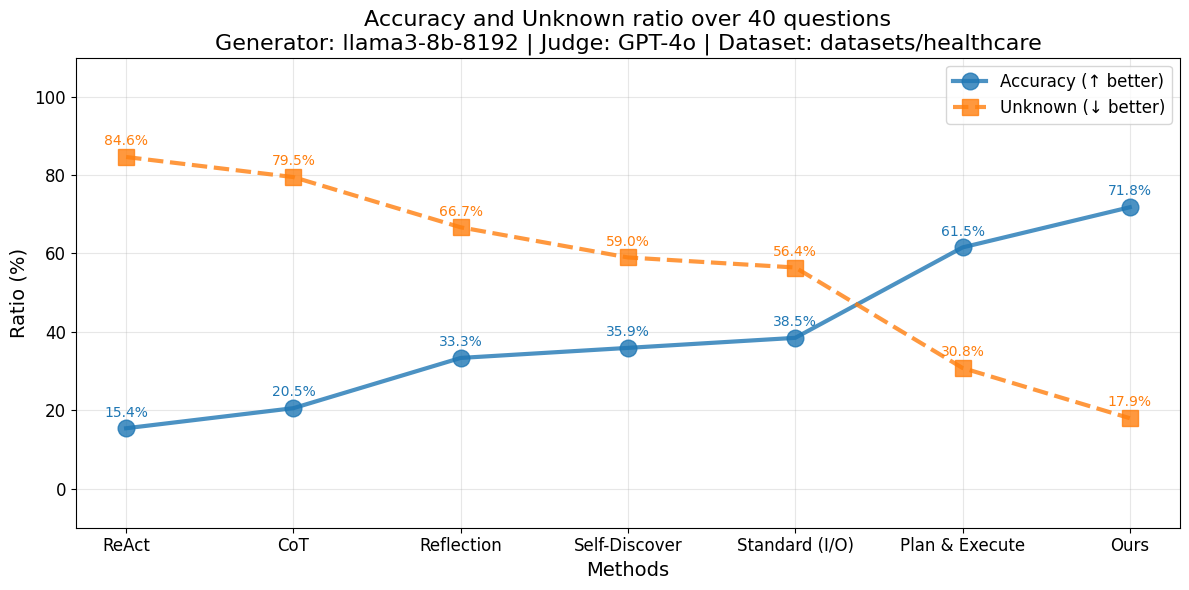

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple
from cama.utils import evaluate_answers_with_unknowns

# load qa list
qa_list = load_from_json(f'{dataset_folder}/qa_list.json')

def plot_scores_with_unknowns(scores: Dict[str, Tuple[float, float]], llm_name: str):
    """
    Creates a single line plot showing both accuracy scores and unknown ratios.

    Parameters:
    scores (Dict[str, Tuple[float, float]]): A dictionary where keys are method names and values are tuples (accuracy, unknown_ratio).
    llm_name (str): The name of the language model used as the report generator.
    """
    methods = list(scores.keys())
    accuracies = [score[0] for score in scores.values()]
    unknown_ratios = [score[1] for score in scores.values()]

    # Sort methods by accuracy for better visual trend
    sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k])
    methods = [methods[i] for i in sorted_indices]
    accuracies = [accuracies[i] for i in sorted_indices]
    unknown_ratios = [unknown_ratios[i] for i in sorted_indices]

    plt.figure(figsize=(12, 6))

    # Plot both lines on the same graph
    plt.plot(methods, accuracies, marker='o', linewidth=3, color='#1f77b4', markersize=12, label='Accuracy (↑ better)', alpha=0.8)
    plt.plot(methods, unknown_ratios, marker='s', linewidth=3, color='#ff7f0e', markersize=12, label='Unknown (↓ better)', alpha=0.8, linestyle='--')
    
    # Highlight CAMA with different markers
    # cama_index = methods.index("CAMA") if "CAMA" in methods else -1
    # if cama_index != -1:
    #     plt.plot(cama_index, accuracies[cama_index], marker='*', markersize=20, color='#1f77b4', label='CAMA (Acc)', linewidth=0)
    #     plt.plot(cama_index, unknown_ratios[cama_index], marker='P', markersize=20, color='#ff7f0e', label='CAMA (Unk)', linewidth=0)
    
    plt.ylim(-10, 110)
    plt.xlabel('Methods', fontsize=14)
    plt.ylabel('Ratio (%)', fontsize=14)
    plt.title(f'Accuracy and Unknown ratio over 40 questions\nGenerator: {llm_name} | Judge: GPT-4o | Dataset: {dataset_folder}', fontsize=16)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # # Create a custom legend order
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 1]  # Accuracy, Unknown
    # if cama_index != -1:
    #     order.extend([2, 3])  # CAMA (Acc), CAMA (Unk)
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=12)

    # Add value labels on each point with offset for better readability
    for i, (acc, unk) in enumerate(zip(accuracies, unknown_ratios)):
        # if acc > unk:
        plt.text(i, acc + 3, f'{acc:.1f}%', ha='center', fontsize=10, color='#1f77b4')
        plt.text(i, unk + 3, f'{unk:.1f}%', ha='center', fontsize=10, color='#ff7f0e')
        # else:
        #     plt.text(i, acc - 2, f'{acc:.1f}%', ha='center', fontsize=10, color='#1f77b4')
        #     plt.text(i, unk + 2, f'{unk:.1f}%', ha='center', fontsize=10, color='#ff7f0e')

    # save plot in pdf
    # plt.savefig(f'{dataset_folder}/scores_plot_{llm_name}.pdf', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# Example usage:
scores = {
    "Standard (I/O)": evaluate_answers_with_unknowns(qa_list, answers_full_prompt),
    "CoT": evaluate_answers_with_unknowns(qa_list, answers_full_prompt_cot),
    "Ours": evaluate_answers_with_unknowns(qa_list, answers_cama_agent),
    "Reflection": evaluate_answers_with_unknowns(qa_list, answers_reflection),
    "ReAct": evaluate_answers_with_unknowns(qa_list, answers_react),
    "Self-Discover": evaluate_answers_with_unknowns(qa_list, answers_self_discover),
    "Plan & Execute": evaluate_answers_with_unknowns(qa_list, answers_plan_and_execute),
}

plot_scores_with_unknowns(scores, llm_name)